### Assignment 4 Generative Adversarial Nets (Unconditional, 10 pts)


In this exercise, we will implement a Generative Adversarial Net (GAN), specifically, a Wasserstein GAN and train it on the MNIST dataset. *We recommend completing this assignment using Google Colab with Chrome Browser*.

**Submit**
1. (<font color='red'>Doc A</font>) Include the two figures at the end in the pdf generated by the latex file with Exercise 2
2. (<font color='red'>Doc B</font>) The completed *.ipynb file with all the command outputs (can be created by saving the file after finishing the experiment and downloading it from Colab)

## Setup


1. In Colab, open tab Runtime > Change runtime type, choose *python3* and *T4 GPU*.
2. Run the following command to set up the environment. (Takes ~ 1.5 min)



In [ ]:
! pip install --quiet "ipython[notebook]==7.34.0, <8.17.0" "setuptools>=68.0.0, <68.3.0"  "torch==1.13.0" "matplotlib"  "torchvision" 

Let's start with importing our standard set of libraries.

In [1]:
import torch
from torch import nn, optim, autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import sys
%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 2 epoch is sufficient to get full mark. (NOTE THAT 2 epoch takes approximately 1.5 hours to train for CPU)
  print('GPU is not detected. Make sure you have chosen the right runtime type')

Everything looks good; continue


## Dataloaders and hyperparameters (0 pt)

In [2]:
@dataclass
class Hyperparameter:
    batchsize: int          = 64
    num_epochs: int         = 5
    latent_size: int        = 32
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
        
hp = Hyperparameter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                                
dataset  = torchvision.datasets.MNIST("mnist", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, num_workers=1, shuffle=True, drop_last=True, pin_memory=True)

## Building Models (2 pts)

After examining the preprocessing steps, we can now start building the models, including the generator for generating new images from random noise, and a critic of the realness of the image.


In this assignment we adopt the implementation of [DCGAN](https://arxiv.org/pdf/1511.06434), which is a direct extension of [GAN](https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), with convolutional and convolutional-transpose layers in the critic and genrator, respectively. Specifically, we will use the [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layers to upscale the noise.

Moreover, we apply an improved version of [Wasserstein-GAN](https://arxiv.org/pdf/1701.07875) with a [Gradient Penalty](https://arxiv.org/pdf/1704.00028) (you may read Algorithm 1 to fully understand the code we are implementing). 


In [3]:
# Define the generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Add latent embedding layer to adjust the dimension of the input (1 pt)

        # Hint: you should use the hyperparameters defined above

        self.latent_embedding = nn.Sequential(nn.Linear(hp.latent_size , hp.generator_size ))
        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        
        
        # Transposed CNN layers to transfer noise to image 
        
        self.tcnn = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size, kernel_size=4, stride=1, padding= 0),
        nn.BatchNorm2d(hp.generator_size),
        nn.ReLU(inplace=True),
        # upscaling
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size // 2, 3, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 2),
        nn.ReLU(inplace=True),
        # upscaling
        nn.ConvTranspose2d(hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(hp.generator_size // 4, 1, 4, 2, 1),
        nn.Tanh()
        )
        
        
    def forward(self, latent):
        vec_latent = self.latent_embedding(latent).reshape(-1, hp.generator_size, 1, 1)
        return self.tcnn(vec_latent)

    
# Define the critic

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        # CNN layers that perform downscaling
        self.cnn_net = nn.Sequential(
        nn.Conv2d(1, hp.critic_size // 4, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
        nn.InstanceNorm2d(hp.critic_size, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        )
        
        # Linear layers that produce the output from the features
        self.critic_net = nn.Sequential(
        nn.Linear(hp.critic_size * 4, hp.critic_hidden_size),
        nn.LeakyReLU(0.2, inplace=True), 
            
        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Add the last layer to reflect the output (1 pt)
        
        nn.Linear(hp.critic_hidden_size  ,1)

        # Hint: Given an image, the output of the critic is a value (or a scalar)
        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        )
    
    def forward(self, image):
        cnn_features = self.cnn_net(image)
        return self.critic_net(cnn_features)


## Before Training 

Next we define the two models and the optimizers. We use the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) algorithm.



In [4]:
critic, generator = Critic().to(device), Generator().to(device)

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4,betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4,betas=(0., 0.9))

## Training pipeline (6 points)


Finally, we perform training on the two networks. The training consists of two steps: (1) Updating discriminators for n_critic steps (such that we have an optimal critic): here we use an aggregation of three loss functions, (a) The real loss (the output scalar of the critic for real images); (b) The fake loss (same value for fake images); (c) The [gradient penalty](https://arxiv.org/pdf/1704.00028). (2) Updating generators by only considering the fake loss (to fool the critic).


In [5]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
fixed_noise = torch.randn((64, hp.latent_size), device=device)
grad_tensor = torch.ones((hp.batchsize, 1), device=device)
start_time = time.time()

# ref : https://www.youtube.com/watch?v=ILpC3b-819Q
def loss_fn(y_pred, y_true):
    return -torch.mean(y_pred * y_true)

for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)

        real_labels = torch.ones(hp.batchsize, device=device) # real label = 1

        # Update Critic
        critic_optimizer.zero_grad()

        # (a) Real loss
        critic_output_real = critic(real_images)
        critic_loss_real  = loss_fn(critic_output_real, real_labels)  #changed critic_output_real.mean() #

        # (b) Fake loss

        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Implement the fake loss

        # (1) Generating a noise tensor (of dimension (batch_size, latent_size)), you are required to
        # use the hyperparameters in the hp class (0.5 pt)

        noise = torch.randn((hp.batchsize , hp.latent_size) , device = device)

        # (2) Generate fake images using the generator (hint: you are not supposed to perform gradient
        # update on the generator) (1.5 pts)


        fake_image = generator.forward(noise)
        fake_labels = -real_labels # fake label = -1
        flipped_fake_labels = real_labels # here, fake label = 1

        # (3) Calculate the fake loss using the output of the generator (1 pt)
        critic_output_fake = critic(fake_image.detach())
        critic_loss_fake = loss_fn(critic_output_fake, fake_labels) #critic_output_fake.mean()  #

        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^

        #  (c) Gradient penalty
        alpha = torch.rand((hp.batchsize, 1, 1, 1), device=device)
        interpolates = (alpha * real_images + ((1. - alpha) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates)
        gradients = autograd.grad(outputs=d_interpolates, inputs = interpolates, grad_outputs=grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()

        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Implement the aggregated loss using the above three components, be careful with the signs (1 pt)

        critic_loss = 0.5*(critic_loss_real + critic_loss_fake ) + gradient_penalty

        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^

        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()


            #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
            # Implement the generator loss (2 pts)

            noise = torch.randn((hp.batchsize , hp.latent_size) , device = device)
            fake_image =  generator.forward(noise)
            critic_output_fake = critic(fake_image)
            generator_loss = loss_fn(critic_output_fake, flipped_fake_labels)  #critic_output_fake.mean() #

            # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^

            generator_loss.backward()
            generator_optimizer.step()

        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")

        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad(): fake_images = generator(fixed_noise).cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1

/home/prajwal/anaconda3/envs/pytorch2/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[ 0/5][      0][    1.82s]	d_loss/g_loss:  2.0/-0.8	
[ 0/5][    100][   14.34s]	d_loss/g_loss: -3e+02/-3.3e+02	
[ 0/5][    200][   27.02s]	d_loss/g_loss: -6.3e+02/-7.2e+02	
[ 0/5][    300][   39.84s]	d_loss/g_loss: -1.6e+01/-1.1e+03	
[ 0/5][    400][   52.77s]	d_loss/g_loss: -1.5e+03/-1.6e+03	
[ 0/5][    500][   65.67s]	d_loss/g_loss: -1.9e+03/-2.1e+03	


KeyboardInterrupt: 

## Visualization (2 pts)

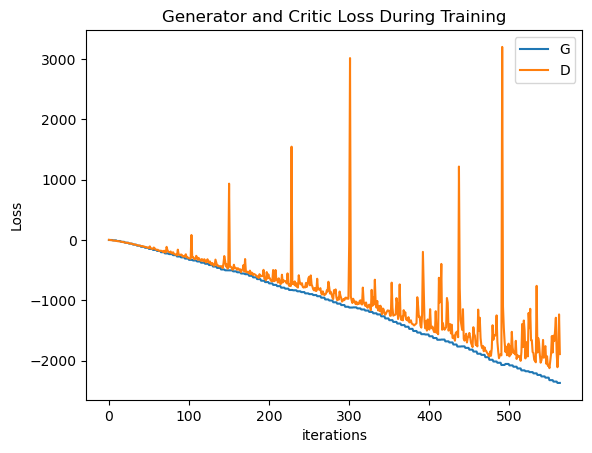

In [6]:
# Visualize the loss
# include the figure in the latex file (1 pt)
plt.title("Generator and Critic Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

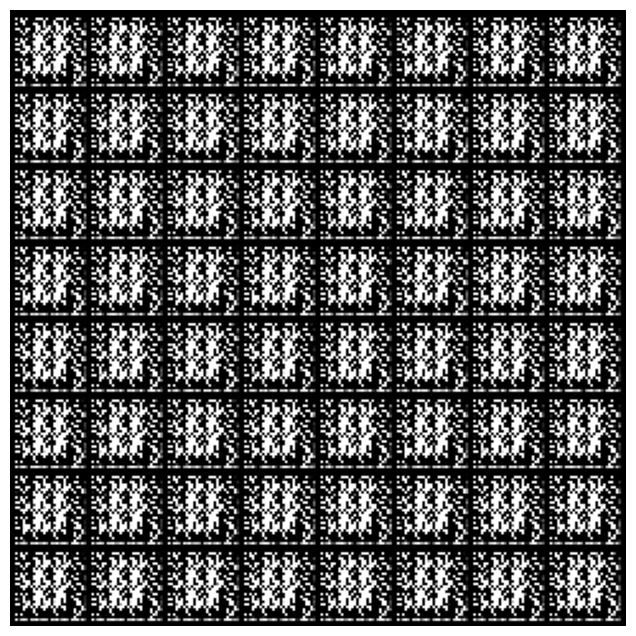

In [7]:
# Visualize the generation (you may scroll to see the animation of training)
# include the final figure in the latex file (1 pt)
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list] 
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())